# A gentle introduction to Stable Diffusion: Part 4 - Convolutional UNet de-noiser

Hello and welcome (back) to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the fourth section out of five: a look at the Variational Auto Encoder. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/unboxing-genai/)

1. Introduction to Latent Diffusion Models
2. The CLiP text embedding model
3. Variational Auto Encoders for image compression
4. Convolutional UNet de-noiser
5. Conclusion - putting it all together


## Part 4: Convolutional UNet de-noiser

We now turn our attention to the core component in Stable Diffusion v1.4: the denoising algorithm.

Let's load the model first.


In [ ]:
# Install some required libraries
!pip install -e git+https://github.com/WillSH97/stable_diffusion_explainer.git@utils#egg=SD_utils --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.7 MB/s eta 0:00:00


In [1]:
# Set up imports and configuration

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import requests
from io import BytesIO

from PIL import Image
from torchvision import transforms as tfms
import os

from SD_utils import * #importing vars and funcs from previous tutorials 


/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:

# Load the model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# Halve the precision to use less memory and run faster for educational purposes
unet = unet.to(torch_device).half()



We'll also use an additional computational piece of the puzzle called a 'scheduler'. We will explore how this works a bit later, but for now, just understand that it adds a certain amount of noise to the image we're generating at each timestep, and it tells the UNet how much noise to expect. We're going to use this function to add our noise.


In [23]:
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# This is setting the number of theoretical denoising steps we're doing. This number is arbitrary - ignore it for now.
scheduler.set_timesteps(100)

# This is setting the step which we're denoising from - also ignore it for now.
demo_timestep = 80

For this demo, let's take our image of Elon Musk, embed it to the latent space, add some noise, and then ask our UNet to denoise it.

In [24]:

# Creating random noise in the same shape as our latent image data from earlier
noise = torch.randn_like(elon_encoded_sample)

# adding the noise pattern through the scheduler
noisy_elon_latents = scheduler.add_noise(
    elon_encoded_sample,
    noise,
    timesteps=torch.tensor([scheduler.timesteps[demo_timestep]])
)


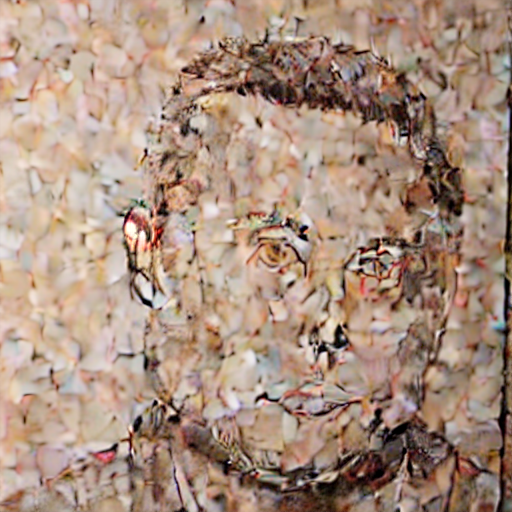

In [25]:

elon_decoded_img_noise = VAE_decode(noisy_elon_latents)

elon_decoded_img_noise


Now we're going to have to create an empty word embedding. This is because our UNet is "conditional", so it needs a text embedding input to be conditioned on. If you pass no words in, it's effectively not "conditioned".

In [26]:

uncond_embeddings = sentence_embedder([''])[0]


We can now start denoising!

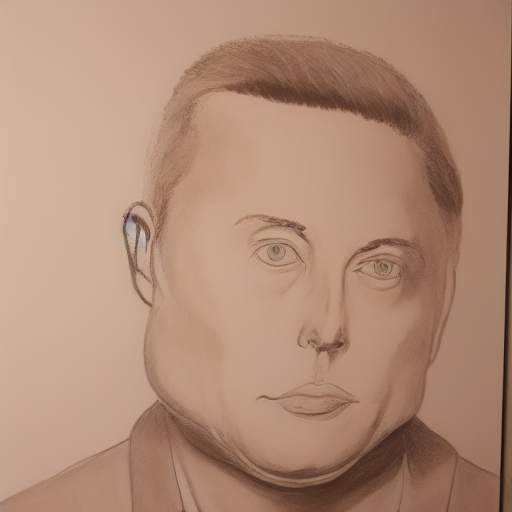

In [27]:

# Scale the latents for the unet input
latent_model_input = scheduler.scale_model_input(
    noisy_elon_latents,
    scheduler.timesteps[demo_timestep]
).half()

# passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
with torch.no_grad():
    noise_pred = unet(
        latent_model_input,
        scheduler.timesteps[demo_timestep],
        encoder_hidden_states=uncond_embeddings
    ).sample

# output the clean latent
clean_latents = scheduler.step(
    noise_pred,
    scheduler.timesteps[demo_timestep],
    noisy_elon_latents
).pred_original_sample

elon_decoded_img_denoised_PIL = VAE_decode(clean_latents)

elon_decoded_img_denoised_PIL


Look at that! Now let's compare that to the original picture, and make a note of a few things

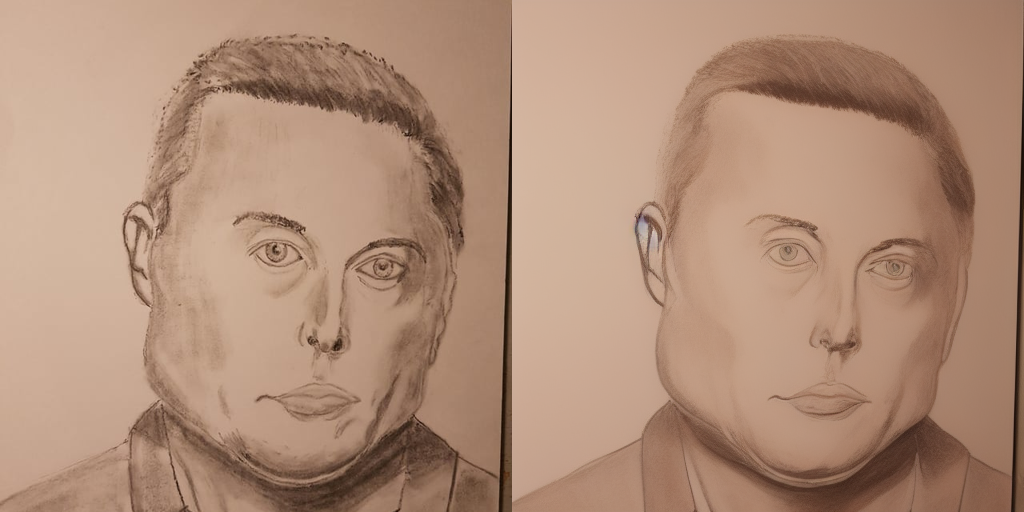

In [28]:

image_grid([elon_img, elon_decoded_img_denoised_PIL], 1, 2)


Our denoised image definitely looks quite clean! However, we can see that the inherent structure of Elon's face is quite different. The broad shapes/shades are there, but the overall structure is sort of more smoothed out, and cleaner. This is where iteratively denoising comes into play - when smaller amounts of noise are injected and removed, higher levels of detail are preserved through the denoising algorithm! Here, try changing the number of scheduler timesteps and demo timestep, and see what that does to the amount of noise that's input into the latents, and the similarity in denoised results of the outputs.

In [29]:

def denoising_explore(num_timesteps, test_timestep):
    """XXX AJS Docstring needed"""
    test_timestep = test_timestep-1
    scheduler.set_timesteps(num_timesteps)
    noise = torch.randn_like(elon_encoded_sample)
    noisy_elon_latents = scheduler.add_noise(
        elon_encoded_sample,
        noise,
        timesteps=torch.tensor([scheduler.timesteps[test_timestep]])
    )
    
    #scale the latents for the unet input
    latent_model_input = scheduler.scale_model_input(
        noisy_elon_latents,
        scheduler.timesteps[test_timestep]
    ).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            scheduler.timesteps[test_timestep],
            encoder_hidden_states=uncond_embeddings
        ).sample
    
    # output the clean latent
    clean_latents = scheduler.step(
        noise_pred,
        scheduler.timesteps[test_timestep],
        noisy_elon_latents
    ).pred_original_sample
    
    elon_decoded_img_denoised_PIL = VAE_decode(clean_latents)
    return elon_decoded_img_denoised_PIL


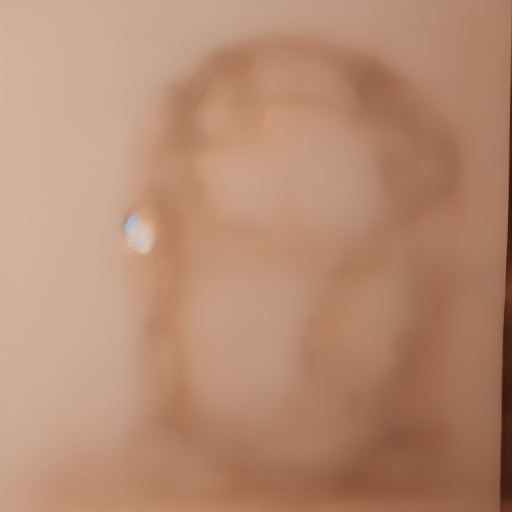

In [30]:
# ITERATE HERE
denoising_explore(num_timesteps=10,
                 test_timestep=4)
    

Now that we've finished looking at the UNet, we've looked at every part of the Stable Diffusion v1.4 model cascade! So we can finally put everything we've learend together in the last section of this explainer.